In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import eval_tools as eval

In [2]:
# load data
exp_df = pd.read_csv('results/experiment_results_exp-3.csv')

In [3]:
# compute accuracy and recall for each doas estimated by each method within a threshold of 10 degrees

def calc_ae(a,b):
    x = np.abs(a-b)
    return np.min(np.array((x, np.abs(360-x))), axis=0)

exp_df['ang_error'] = calc_ae(
    np.rad2deg(exp_df['doas_est_az']), 
    np.rad2deg(exp_df['doas_ref_az'])
)

ang_error_threshold_choices = [5, 10, 15, 20]

# compute accuracy and recall based on the frame id as in DCASE Task 3
unique_frame_ids = exp_df['frame_id'].unique()
unique_method_ids = exp_df['method_id'].unique()

df_thresholds = pd.DataFrame()

for frame_id in tqdm(unique_frame_ids, desc='frame'):
    df_frame = exp_df[exp_df['frame_id'] == frame_id]
    
    for method_id in unique_method_ids:
        df_method = df_frame[df_frame['method_id'] == method_id]    
                
        assert len(df_method) == np.unique(df_method['doas_est_az']).shape[0] == np.unique(df_method['n_sources'])
            
        # accuracy and mean error
        for thr in ang_error_threshold_choices:
            
            accuracy = np.sum(df_method['ang_error'] <= thr) / len(df_method)
            error = np.mean(df_method[df_method['ang_error'] <= thr]['ang_error'])

            df_ = pd.DataFrame({
                "frame_id": frame_id,
                "method_id": method_id,
                "accuracy": accuracy,
                "mean_error": error,
                "threshold": thr
            }, index=[0])
            df_thresholds = pd.concat([df_thresholds, df_], ignore_index=True)

frame: 100%|██████████| 150/150 [00:35<00:00,  4.17it/s]


In [4]:
df_merge = exp_df.merge(df_thresholds, on=['frame_id', 'method_id'])

In [5]:
print('accuracy for 5 degree, the higher the better')
df_pivot = df_merge[
        (df_merge['seed'] == 13)
        & (df_merge['threshold'] == 10)
        & (df_merge['duration'] == 0.5)
].pivot_table(
        values='accuracy', 
        columns=['n_sources'],
        index=['sv_method', 'nObs', 'seed', 'loc_method'], 
        aggfunc='mean'
)
df_pivot.style.background_gradient(cmap='viridis', axis=1)

accuracy for 5 degree, the higher the better


['music' 'srp_phat' 'wishart' 'inv_wishart' 'alpha']


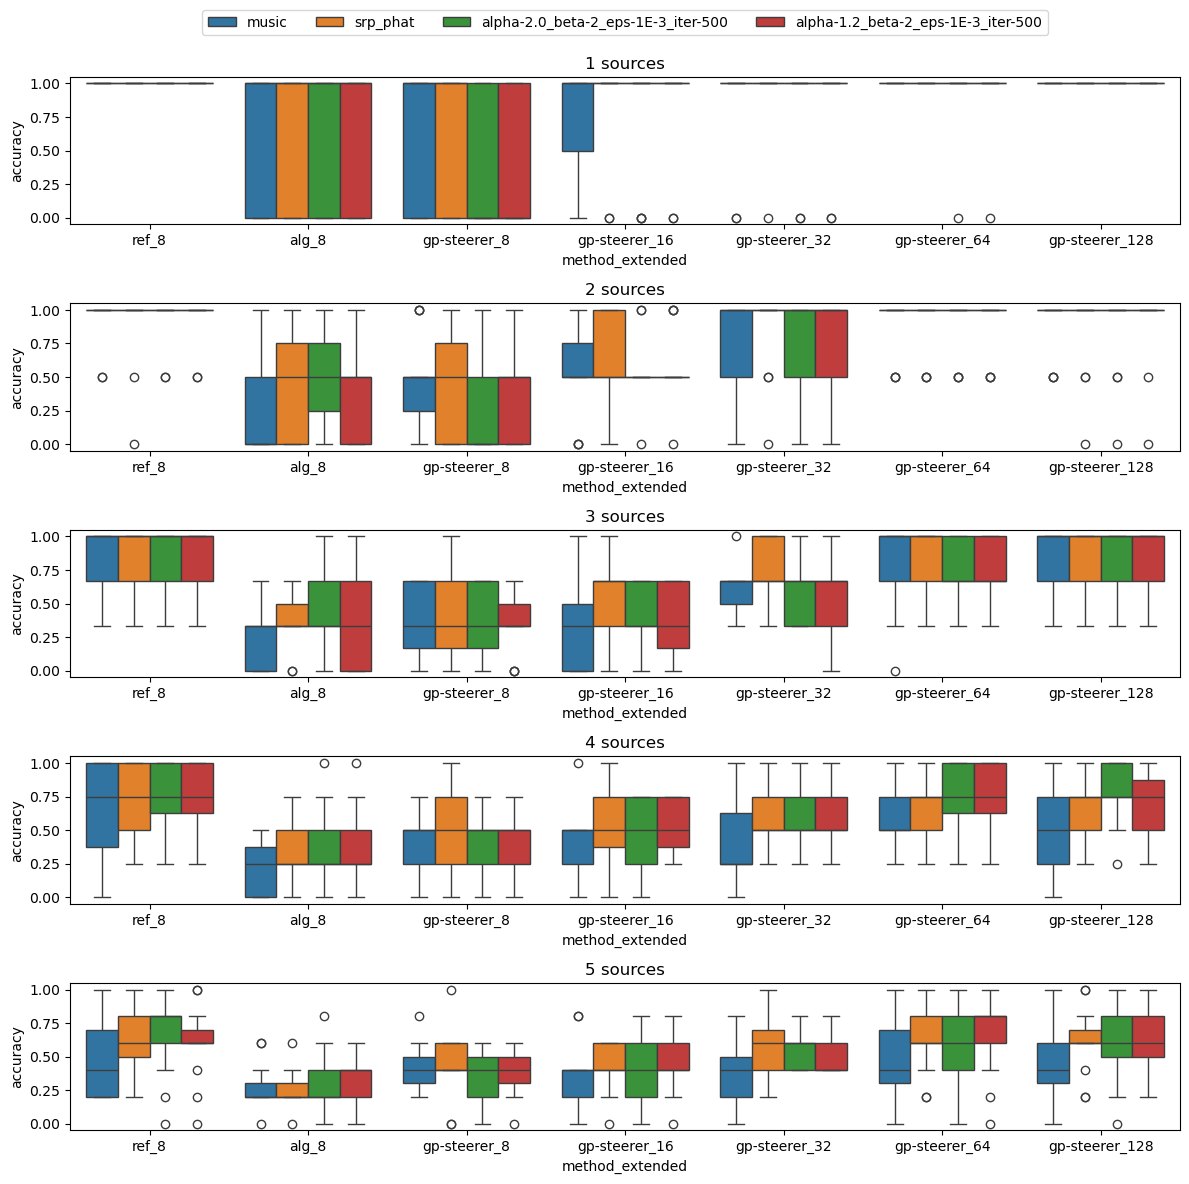

In [20]:
n_max_sources = np.max(df_merge['n_sources'])
loc_methods = np.unique(df_merge['loc_method'])
sv_methods = np.unique(df_merge['sv_method'])

fig, axarr = plt.subplots(n_max_sources, 1, figsize=(12, 12))

df_merge['loc_method_simple'] = df_merge['loc_method'].apply(lambda x: x.split('-')[0])

print(df_merge['loc_method_simple'].unique())

for i, n_sources in enumerate(range(n_max_sources)):
    # for j, loc_method in enumerate(loc_methods):

        df_ = df_merge[
                (df_merge['seed'] == 13)
            & (df_merge['threshold'] == 10)
            & (df_merge['n_sources'] == n_sources+1)
            & (df_merge['record_id'] == 's0')
            & (df_merge['duration'] == 0.5)
            & (df_merge['loc_method_simple'].isin(['srp_phat', 'music', 'alpha']))
        ]
        
        df_ = df_.assign(method_extended=df_['sv_method'] + '_' + df_['nObs'].astype(str))
    
        sns.boxplot(
            data=df_,
            x='method_extended',
            y='accuracy',
            hue='loc_method',
            # y='mean_error',
            ax=axarr[i],
        )
        # place legend above plot
        if i == 0:
            axarr[i].legend(loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=4)
        else:
            axarr[i].get_legend().remove()
        axarr[i].set_title(f'{n_sources+1} sources')
plt.tight_layout()

In [23]:
df_ = df_merge[
        (df_merge['seed'] == 13)
    & (df_merge['threshold'] == 10)
    & (df_merge['n_sources'] == n_sources+1)
    & (df_merge['record_id'] == 's0')
    & (df_merge['duration'] == 0.5)
    & (df_merge['loc_method_simple'].isin(['srp_phat']))
    & (df_merge['sv_method'].isin(['ref']))
]

In [24]:
df_

,exp_name,time,record_id,num_srcs,src_ids,doas_est_idx,doas_ref_idx,doas_ref_az,doas_est_az,doas_ref_el,...,freq_max,sv_method,nObs,seed,sv_normalization,ang_error,accuracy,mean_error,threshold,loc_method_simple
81941,exp-3_nSrc-5_doas-[44 47 53 0 3]_type-speech...,20250306-113341,s0,5,0,38,44,4.607669,3.979351,1.570796,...,4000,ref,8,13,True,36.0,0.6,6.0,10,srp_phat
83301,exp-3_nSrc-5_doas-[37 43 12 8 9]_type-speech...,20250306-113349,s0,5,0,37,37,3.874631,3.874631,1.570796,...,4000,ref,8,13,True,0.0,0.6,4.0,10,srp_phat
84661,exp-3_nSrc-5_doas-[40 15 45 8 22]_type-speech...,20250306-113357,s0,5,0,31,40,4.188790,3.246312,1.570796,...,4000,ref,8,13,True,54.0,0.8,1.5,10,srp_phat
86021,exp-3_nSrc-5_doas-[42 24 57 3 56]_type-speech...,20250306-113406,s0,5,0,46,42,4.398230,4.817109,1.570796,...,4000,ref,8,13,True,24.0,0.4,3.0,10,srp_phat
87381,exp-3_nSrc-5_doas-[58 46 55 5 1]_type-speech...,20250306-113414,s0,5,0,56,58,6.073746,5.864306,1.570796,...,4000,ref,8,13,True,12.0,0.2,6.0,10,srp_phat
88741,exp-3_nSrc-5_doas-[35 14 47 38 54]_type-speech...,20250306-113423,s0,5,0,30,35,3.665191,3.141593,1.570796,...,4000,ref,8,13,True,30.0,0.6,0.0,10,srp_phat
90101,exp-3_nSrc-5_doas-[10 9 35 20 42]_type-speech...,20250306-113431,s0,5,0,21,10,1.047198,2.199115,1.570796,...,4000,ref,8,13,True,66.0,0.6,2.0,10,srp_phat
91461,exp-3_nSrc-5_doas-[47 4 25 54 3]_type-speech...,20250306-113439,s0,5,0,47,47,4.921828,4.921828,1.570796,...,4000,ref,8,13,True,0.0,0.8,0.0,10,srp_phat
92821,exp-3_nSrc-5_doas-[ 3 20 49 41 5]_type-speech...,20250306-113448,s0,5,0,53,3,0.314159,5.550147,1.570796,...,4000,ref,8,13,True,60.0,0.8,1.5,10,srp_phat
94181,exp-3_nSrc-5_doas-[28 53 54 56 59]_type-speech...,20250306-113456,s0,5,0,31,28,2.932153,3.246312,1.570796,...,4000,ref,8,13,True,18.0,0.2,0.0,10,srp_phat
